In [1]:
# local version, copied from Eagle
# JLCY 2021-02-12

# based on: 
# /a2e-mmc/assessment/blob/master/examples/UsingTSLISToutput.ipynb

# developed on Mac WE42120

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram

data_dir = '/Users/leec813/Documents/mmc/sgp/data/'
obs_dir = data_dir+'obs/'
era_wrf_all_dir = '/Users/leec813/Documents/mmc/sgp/data/era5/'
gfs_wrf_all_dir = '/Users/leec813/Documents/mmc/sgp/data/gfs/'

# time step of wrf runs:
erad01_wrf_dt = 6
erad02_wrf_dt = 2
gfs_wrf_dt = 9

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(data_dir+'data-dir-name.csv', index_col=0)

# obs
wp_winds_ncs = obs_dir+'sgpdlprofwind4newsC1.c1/*.nc'
# wp_vstat_ncs = obs_dir+'sgpdlprofwstats4newsC1.c1/*.nc'

wp_winds = xr.open_mfdataset(wp_winds_ncs)
# wp_vstat = xr.open_mfdataset(wp_vstat_ncs)

# According to Rob Newsom, lidar data taken < 100 m need to be thrown out. 
toss_wp_data_below_height = 100

In [2]:
wp_var_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}

def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    # wind speed
    ds['ws'] = np.sqrt(ds['u']**2 + ds['v']**2)
    
    # wind direction
    ds['wd'] = np.mod(180 + np.rad2deg(np.arctan2(ds['u'], ds['v'])), 360) # checked wd, correct

    return ds

def get_wp_height_list(wp_ds):
    
    # select data at few heights above threshold height
    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height))
                           .values[0:10])
    
    return [x for x in wp_height_list if str(x) != 'nan']

def plot_ts_at_wp_hgt(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_title): 

        lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
        lw = 1
        
        # reverse height list, useful for plotting
        wp_height_list = get_wp_height_list(wp_ds)[:len(lc_list)][::-1]

        for hgt, lc in enumerate(lc_list): 

            # slice of data at each height
            wrf_slice = wrf_ds.sel(height=wp_height_list[hgt])
            wp_slice = wp_ds.sel(height=wp_height_list[hgt])

            plt.plot(wrf_slice['datetime'], wrf_slice[wrf_var], 
                     label=str(np.round(wrf_slice['height'].values).astype(int))+' m', 
                     c=lc, linewidth=lw)
            plt.plot(wp_slice['time'], wp_slice[wp_var], c=lc, linewidth=lw, linestyle='--')

        plt.xticks(rotation='vertical')
        # 24 hours of data in plot
        plt.xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
        plt.ylabel(var_title)
        
        plt.title(wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)
        plt.legend(title=wrf_run)
        
        plt.show()

def read_wp_wrf_1day(obs, eval_date): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    era_wrf_dir = era_wrf_all_dir+date_col['era']+'/'

    erad01_file_name = 'c1.d01'
    erad01_file_path = era_wrf_dir+erad01_file_name
    erad01_tower = Tower(erad01_file_path)

    erad02_file_name = 'c1.d02'
    erad02_file_path = era_wrf_dir+erad02_file_name
    erad02_tower = Tower(erad02_file_path)

    gfs_wrf_dir = gfs_wrf_all_dir+date_col['gfs']+'/'
    
    gfs_file_name = 'SGP.d01'
    gfs_file_path = '{}{}'.format(gfs_wrf_dir, gfs_file_name)
    gfs_tower = Tower(gfs_file_path)

    # simulation start time:
    # era & gfs runs have the same start times
    wrf_start = date_col['wrf_start']

    tower_list = [erad01_tower, erad02_tower, gfs_tower]
    dt_list = [erad01_wrf_dt, erad02_wrf_dt, gfs_wrf_dt]

    erad01_ds = read_tower_to_ds(erad01_tower, wrf_start, erad01_wrf_dt, wrf_height_list)
    erad02_ds = read_tower_to_ds(erad02_tower, wrf_start, erad02_wrf_dt, wrf_height_list)
    gfs_ds = read_tower_to_ds(gfs_tower, wrf_start, gfs_wrf_dt, wrf_height_list)
            
    return obs_ds, erad01_ds, erad02_ds, gfs_ds

def plot_wp_wrf_ts_taydiag(obs, eval_date, lev_i=0): 

    obs_ds, erad01_ds, erad02_ds, gfs_ds = read_wp_wrf_1day(obs, eval_date)
    
    wrf_dict = {'erad01': erad01_ds, 'erad02': erad02_ds, 'gfs': gfs_ds}

    # get start & end time to trim time series
    time_start = np.max([erad01_ds['datetime'].min().values, erad01_ds['datetime'].min().values, 
                       gfs_ds['datetime'].min().values, obs_ds['time'].min().values])
    time_end = np.min([erad01_ds['datetime'].max().values, erad01_ds['datetime'].max().values, 
                       gfs_ds['datetime'].max().values, obs_ds['time'].max().values])

    # start w/ obs
    time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']

    # refer to the most infrequent data series
    # need matching time dimension to calculate correlation, etc. 
    for model in [erad01_ds, erad02_ds, gfs_ds]: 

        model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']

        if time_freq.shape > model_time_freq.shape: 

            time_freq = model_time_freq
            
    obs_height_list = get_wp_height_list(obs_ds)

    obs_slice = obs_ds.sel(height=obs_height_list[0], time=time_freq, method='nearest')
    erad01_slice = erad01_ds.sel(height=obs_height_list[0], datetime=time_freq, method='nearest')
    erad02_slice = erad02_ds.sel(height=obs_height_list[0], datetime=time_freq, method='nearest')
    gfs_slice = gfs_ds.sel(height=obs_height_list[0], datetime=time_freq, method='nearest')

    for wrf_var, var in wp_var_dict.items():
        
            for wrf_run, wrf_ds in wrf_dict.items(): 
                
                plot_ts_at_wp_hgt(eval_date, wrf_run, wrf_ds, obs_ds, wrf_var, var[0], var[1])
    
            models = {}
            models['erad01'] = erad01_slice[wrf_var]
            models['erad02'] = erad02_slice[wrf_var]
            models['gfs'] = gfs_slice[wrf_var]

            fig = plt.figure(figsize=(8, 8))
            td = TaylorDiagram(obs_slice[var[0]].std().values, label='lidar', fig=fig,
                               srange=(0, 1.6), extend=False,
                               corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
                               #minorcorrticks=np.arange(0.05,0.9,0.1),
                               #stdevticks=np.arange(0.2,2,0.2),
                               labelsize='x-large')

            for name, series in models.items():
                corr_xy = np.corrcoef(np.squeeze(obs_slice[var[0]]), np.squeeze(series))[0,1]
                R2 = corr_xy**2
                stdev = series.std().values
                # print(name, stdev, R2)
                td.add_sample(stdev, R2, marker='o', ms=10, ls='', alpha=0.7, label=name)

            td.add_grid()

            contours = td.add_contours(levels=15, colors='0.5')
            plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

            fig.legend(td.samplePoints,
                       [ p.get_label() for p in td.samplePoints ],
                       numpoints=1, prop=dict(size='medium'), loc='upper right')

            plt.title(var[0]+' @ '+str(np.round(obs_slice['height'].values).astype(int))+' m')

            plt.show()

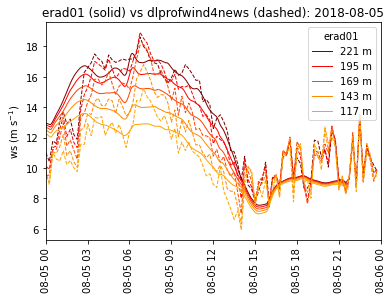

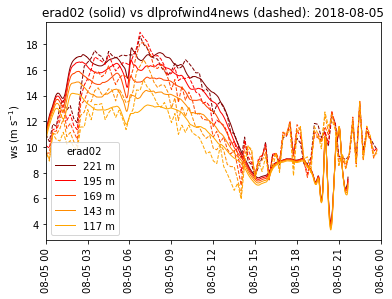

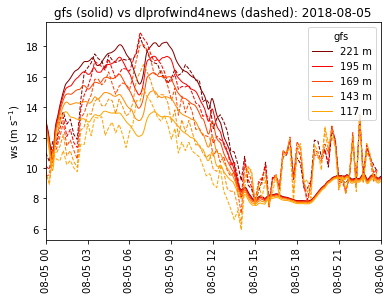

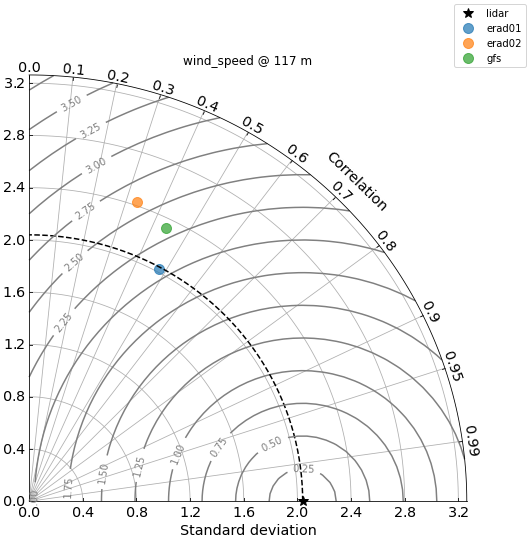

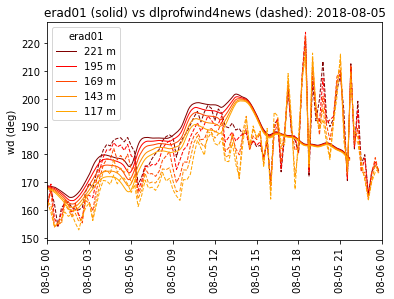

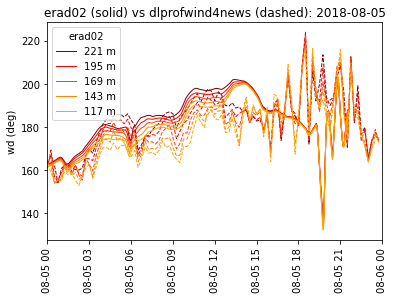

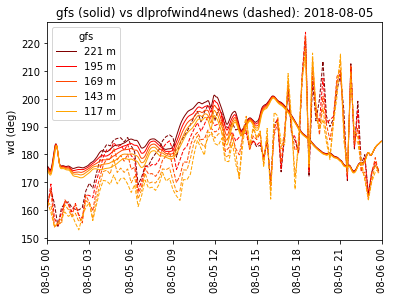

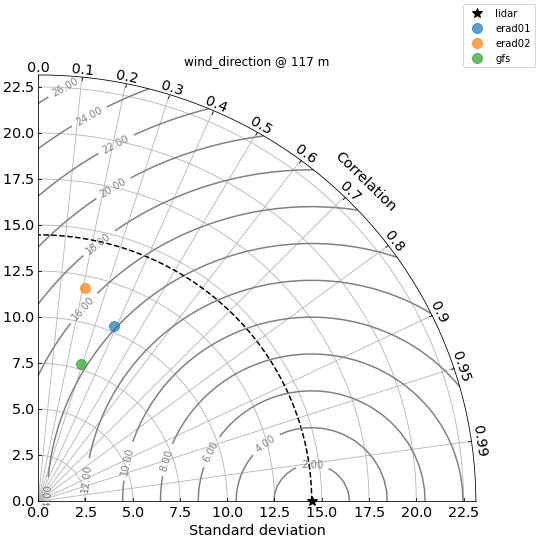

In [3]:
plot_wp_wrf_ts_taydiag(wp_winds, '2018-08-05')

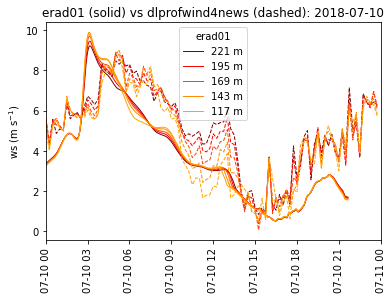

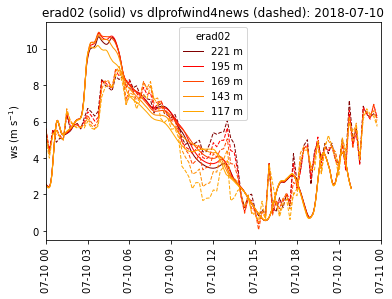

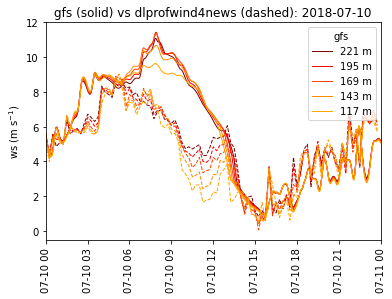

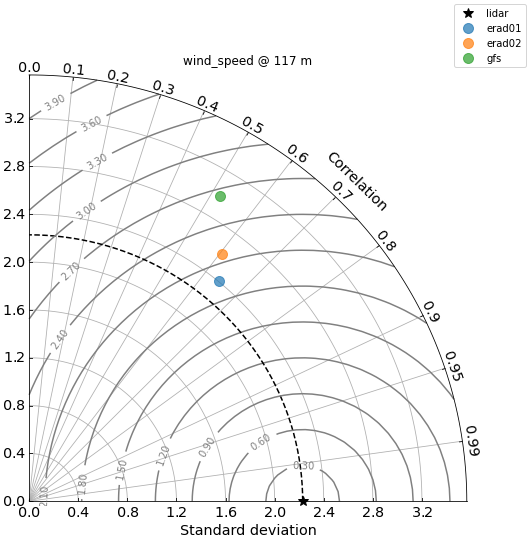

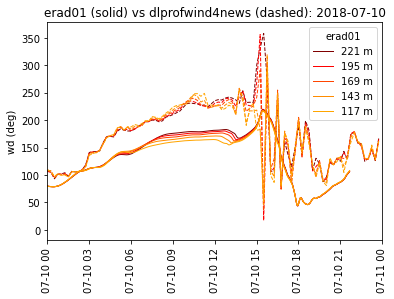

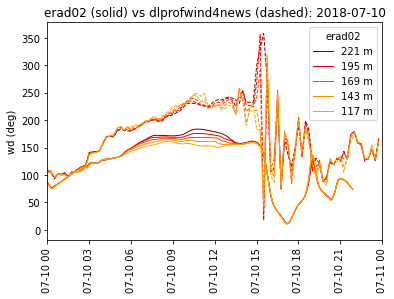

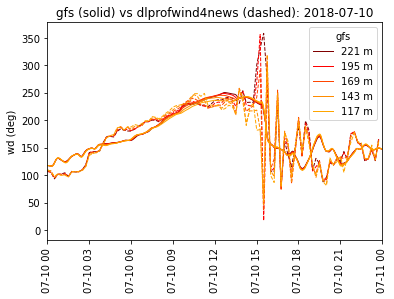

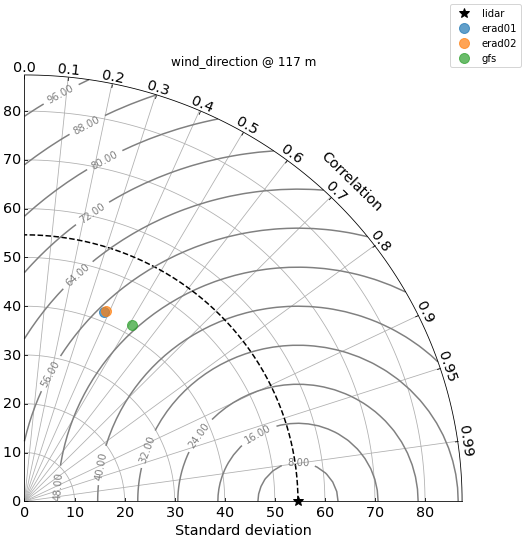

In [4]:
plot_wp_wrf_ts_taydiag(wp_winds, '2018-07-10')

In [ ]:
obs_ds, erad01_ds, erad02_ds, gfs_ds = read_wp_wrf_1day(wp_winds, '2018-07-10')

# obs

# wrf

# compare

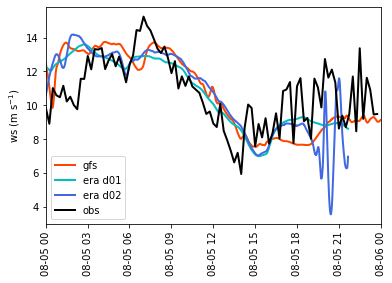

In [53]:
lw = 2
plt.plot(gfs_ds['datetime'], gfs_ds['ws'][:, 1], label='gfs', c='orangered', linewidth=lw)
plt.plot(erad01_ds['datetime'], erad01_ds['ws'][:, 1], label='era d01', c='c', linewidth=lw)
plt.plot(erad02_ds['datetime'], erad02_ds['ws'][:, 1], label='era d02', c='royalblue', linewidth=lw)
plt.plot(wp_winds_seg['time'], wp_winds_seg['wind_speed'][:, 1], label='obs', c='k', linewidth=lw)
plt.xticks(rotation='vertical')
plt.xlim(parser.parse('2018-08-05'), parser.parse('2018-08-06'))
plt.ylabel(r'ws (m s$^{-1}$)')
plt.legend()
plt.show()